# 2.1 Sensitivity Analysis

## Introduction

A first approach to identify the most important input features is sensitivity analysis. It is based on the model's locally evaluated gradients or some other local measure of variation. A common formulation of sensitivity analysis defines relevance scores as

$$R_i(x) = \left( \frac{\partial f}{\partial x_i} \right)^2$$

where the gradient is evaluated at the data point $x$. Put simply, the relevance score indicates how influential a particular data point was on the DNN's decision. Therefore, the most relevant input features are those to which the output is most sensitive (high relevance scores). The relevance score can be calculated simply using backpropagation.

However, it is important to note that sensitivity analysis does not provide an explicit explanation of the function value $f(x)$, but rather suggestions. For instance, when applying sensitivity analysis to a DNN detecting cars, we answer the question *"what makes this image more/less a car"* rather than the more basic question *"what makes this image a car?"*.

## Tensorflow Walkthrough

### 1. Import Dependencies

In [1]:
import os

from tensorflow.examples.tutorials.mnist import input_data
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np

from models.models_2_1 import MNIST_DNN, MNIST_CNN

%matplotlib inline

mnist = input_data.read_data_sets("MNIST_data/", one_hot=True)

logdir = './tf_logs/2_1_SA/'
ckptdir = logdir + 'model'

if not os.path.exists(logdir):
    os.mkdir(logdir)

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


### 2. Building Graph

In this step, a regular CNN classifier is initialized and necessary nodes for model training is added onto the graph. For sensitivity analysis, we only need three placeholders. `training` to indicate that we do not use dropout when during inference, `X` in order to pass test images into the computation graph and `logits` which is necessary to compute the gradient (we need to compute the gradient of `X` with respect to `logits`). Instead of using a fully connected neural network, I used a convolutional neural network because it provided better sensitivity analysis results.

In [2]:
with tf.name_scope('Classifier'):

    # Initialize neural network
    CNN = MNIST_CNN('CNN')

    # Setup training process
    training = tf.placeholder_with_default(True, shape=[], name='training')
    X = tf.placeholder(tf.float32, [None, 784], name='X')
    Y = tf.placeholder(tf.float32, [None, 10], name='Y')

    logits = CNN(X, training)
    
    tf.add_to_collection('sensitivity_analysis', training)
    tf.add_to_collection('sensitivity_analysis', X)
    tf.add_to_collection('sensitivity_analysis', logits)

    cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=logits, labels=Y))

    optimizer = tf.train.AdamOptimizer().minimize(cost, var_list=CNN.vars)

    correct_prediction = tf.equal(tf.argmax(logits, 1), tf.argmax(Y, 1))
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

cost_summary = tf.summary.scalar('Cost', cost)
accuray_summary = tf.summary.scalar('Accuracy', accuracy)
summary = tf.summary.merge_all()

### 3. Training Network

This is the step where the CNN is trained to classify the 10 digits of the MNIST images. Summaries are written into the logdir and you can visualize the statistics using tensorboard by typing this command: `tensorboard --lodir=./tf_logs`

In [3]:
sess = tf.InteractiveSession()
sess.run(tf.global_variables_initializer())

saver = tf.train.Saver()
file_writer = tf.summary.FileWriter(logdir, tf.get_default_graph())

# Hyper parameters
training_epochs = 15
batch_size = 100

for epoch in range(training_epochs):
    total_batch = int(mnist.train.num_examples / batch_size)
    avg_cost = 0
    avg_acc = 0
    
    for i in range(total_batch):
        batch_xs, batch_ys = mnist.train.next_batch(batch_size)
        _, c, a, summary_str = sess.run([optimizer, cost, accuracy, summary], feed_dict={X: batch_xs, Y: batch_ys})
        avg_cost += c / total_batch
        avg_acc += a / total_batch
        
        file_writer.add_summary(summary_str, epoch * total_batch + i)

    print('Epoch:', '%04d' % (epoch + 1), 'cost =', '{:.9f}'.format(avg_cost), 'accuracy =', '{:.9f}'.format(avg_acc))
    
    saver.save(sess, ckptdir)

print('Accuracy:', sess.run(accuracy, feed_dict={X: mnist.test.images, Y: mnist.test.labels, training: False}))

sess.close()

Epoch: 0001 cost = 0.803324707 accuracy = 0.725854545
Epoch: 0002 cost = 0.300909179 accuracy = 0.903072729
Epoch: 0003 cost = 0.237330427 accuracy = 0.923200001
Epoch: 0004 cost = 0.203142770 accuracy = 0.936672728
Epoch: 0005 cost = 0.184979562 accuracy = 0.941890910
Epoch: 0006 cost = 0.168691518 accuracy = 0.946927276
Epoch: 0007 cost = 0.161904683 accuracy = 0.948472729
Epoch: 0008 cost = 0.154317735 accuracy = 0.951636366
Epoch: 0009 cost = 0.152243613 accuracy = 0.952000004
Epoch: 0010 cost = 0.149849975 accuracy = 0.952672729
Epoch: 0011 cost = 0.145942696 accuracy = 0.953981820
Epoch: 0012 cost = 0.142497789 accuracy = 0.955472730
Epoch: 0013 cost = 0.138159763 accuracy = 0.956981820
Epoch: 0014 cost = 0.135748148 accuracy = 0.957490912
Epoch: 0015 cost = 0.135547261 accuracy = 0.957436366
Accuracy: 0.9907


### 4. Restoring Subgraph

Here we first rebuild the CNN graph from metagraph, restore CNN parameters from the checkpoint and then gather the necessary nodes for prototype generation using the `tf.get_collection()` function (recall prototype subgraph nodes were added onto the 'sensitivity analysis' collection at step 2). We now can calculate the relevance scores using `tf.gradients()` function.

In [4]:
tf.reset_default_graph()

sess = tf.InteractiveSession()

new_saver = tf.train.import_meta_graph(ckptdir + '.meta')
new_saver.restore(sess, tf.train.latest_checkpoint(logdir))

SA = tf.get_collection('sensitivity_analysis')
training = SA[0]
X = SA[1]
logits = SA[2]

gradients = tf.gradients(logits, X)

INFO:tensorflow:Restoring parameters from ./tf_logs/2_1_SA/model


### 5. Calculating Relevance Scores $R_i(x)$

We now calculate the gradient of $X$ with respect to the `logits`.

In [5]:
images = mnist.train.images
labels = mnist.train.labels

sample_imgs = []
for i in range(10):
    sample_imgs.append(images[np.argmax(labels, axis=1) == i][3])

img_gradients = sess.run(gradients, feed_dict={X: sample_imgs, training:False})

sess.close()

### 7. Displaying Images

The gradients are visualized as heat maps over the original digit images. You can see which features/data points influenced the CNN most its decision making.

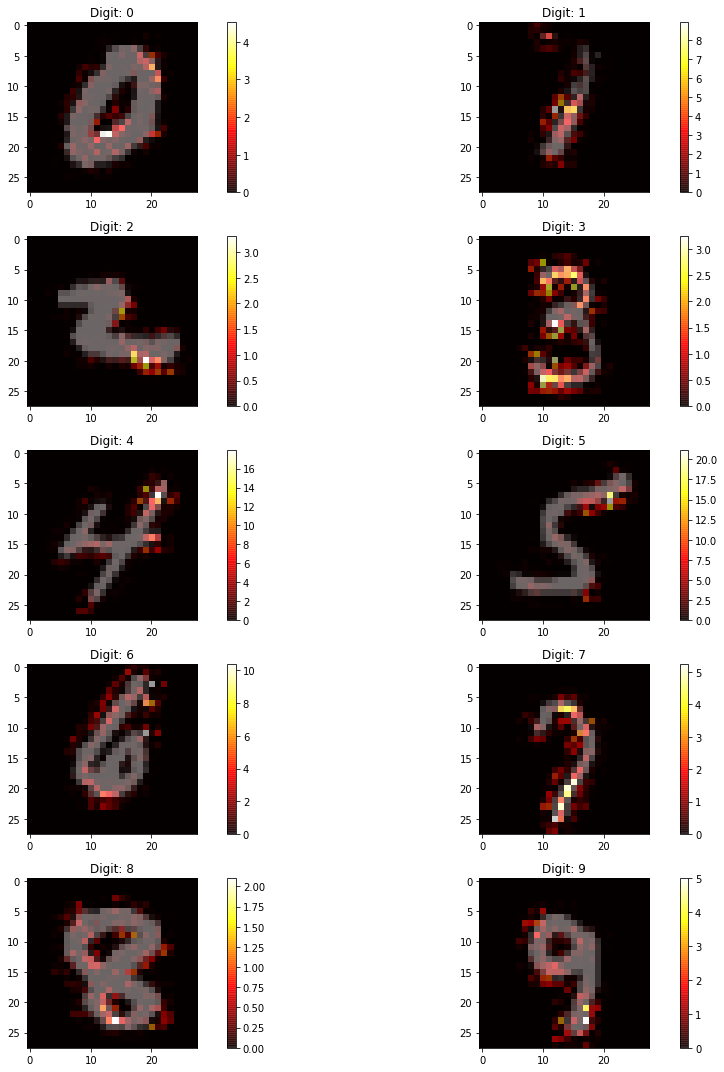

In [6]:
plt.figure(figsize=(15,15))
for i in range(5):
    plt.subplot(5, 2, 2 * i + 1)
    plt.imshow(np.reshape(sample_imgs[2 * i], [28, 28]), cmap='gray')
    plt.imshow(np.reshape(img_gradients[0][2 * i] ** 2, [28, 28]), cmap='hot', alpha=0.6)
    plt.title('Digit: {}'.format(2 * i))
    plt.colorbar()
    
    plt.subplot(5, 2, 2 * i + 2)
    plt.imshow(np.reshape(sample_imgs[2 * i + 1], [28, 28]), cmap='gray')
    plt.imshow(np.reshape(img_gradients[0][2 * i + 1] ** 2, [28, 28]), cmap='hot', alpha=0.6)
    plt.title('Digit: {}'.format(2 * i + 1))
    plt.colorbar()

plt.tight_layout()